<a id = "5" ></a>
# <span style="font-family:serif; font-size:28px;">Loading libraries and data</span>
<a id="loading"></a>

In [1]:
import pandas as pd
import numpy as np
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn import metrics
from sklearn.metrics import roc_curve, precision_recall_curve
from sklearn.metrics import recall_score, confusion_matrix, precision_score, f1_score, accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV, train_test_split


In [3]:
#loading data
data = pd.read_csv('../Data/WA_Fn-UseC_-Telco-Customer-Churn.csv')

In [4]:
#adding timestamps

import random
import time
    
def str_time_prop(start, end, time_format, prop):
    """Get a time at a proportion of a range of two formatted times.

    start and end should be strings specifying times formatted in the
    given format (strftime-style), giving an interval [start, end].
    prop specifies how a proportion of the interval to be taken after
    start.  The returned time will be in the specified format.
    """

    stime = time.mktime(time.strptime(start, time_format))
    etime = time.mktime(time.strptime(end, time_format))

    ptime = stime + prop * (etime - stime)

    return time.strftime(time_format, time.localtime(ptime))


def random_dates(start, end, num_dates):
    dates = []
    for i in range(num_dates):
        dates.append(str_time_prop(start, end, '%Y-%m-%d %H:%M:%S', random.random()))
    return dates

In [5]:
#add time valiable
start_date = "2021-06-01 00:00:00"
end_date = "2021-08-31 11:59:59"
num_dates = len(data)

data['time'] = random_dates(start_date, end_date, num_dates)

<a id = "6" ></a>
# <span style="font-family:serif; font-size:28px;"> Data Manipulation and Remove Missing Values</span>
<a id = "Undertanding the data" ></a>

In [6]:
def manipulate(data):
    #print(len(data))
    data = data.drop(['customerID'], axis = 1)
    data['MonthlyCharges'] = pd.to_numeric(data['MonthlyCharges'], errors='coerce')
    data['TotalCharges'] = pd.to_numeric(data['TotalCharges'], errors='coerce')
    data.dropna(inplace = True)
    #print(len(data))
    return data

In [7]:
numerical_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']
categorical_cols = ['gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']

In [8]:
data = manipulate(data)

<a id = "10" ></a>
# <span style="font-family:serif; font-size:28px;"> Data Preprocessing</span>
<a id = "datapreprocessing" ></a>

<a id = "1111" ></a>
#### **Splitting the data into train and test sets**
<a id = "Split" ></a>

In [9]:
def object_to_int(dataframe_series):
    if dataframe_series.dtype=='object':
        dataframe_series = LabelEncoder().fit_transform(dataframe_series)
    return dataframe_series

def preprocess_data(data, time, val_size):
    data = data.apply(lambda x: object_to_int(x) if x.name != 'time' else x)
    
    #feature_cols
    feature_cols = categorical_cols + numerical_cols
    
    train = data[data['time']<=time].reset_index()
    test = data[data['time'] > time].reset_index()
    
    X_train = train[feature_cols]
    y_train = train['Churn']
    
    X_test = test[feature_cols]
    y_test = test['Churn']
    
    scaler= StandardScaler()

    X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
    X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])

    X_train, X_val, y_train, y_val = train_test_split(X_train.to_numpy(),y_train.to_numpy(),test_size = val_size, random_state = 40, stratify=y_train)
    
    X_test = X_test.to_numpy()
    y_test = y_test.to_numpy()
    
    return X_train, y_train, X_val, y_val, X_test, y_test

def roc_curve_show(y_test, y_pred_prob, model_name):
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
    plt.plot([0, 1], [0, 1], 'k--' )
    plt.plot(fpr, tpr, label=model_name,color = "r")
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(model_name + 'ROC Curve',fontsize=16)
    plt.show()
    
def pr_curve_show(y_test, y_pred_prob, model_name):
    p, r, thresholds = precision_recall_curve(y_test, y_pred_prob)
    #plt.plot([0, 1], [0, 1], 'k--' )
    plt.plot(p, r, label=model_name,color = "r")
    plt.xlabel('Precision')
    plt.ylabel('Recall')
    plt.title(model_name + 'PR Curve',fontsize=16)
    plt.show()


In [10]:
feature_cols = categorical_cols + numerical_cols

### Train Test Split

In [11]:
X_train, y_train, X_val, y_val, X_test, y_test = preprocess_data(data, "2021-07-31 23:59:59", 0.2)
print(X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape)

(3793, 19) (3793,) (949, 19) (949,) (2290, 19) (2290,)


<a id = "11" ></a>
# <span style="font-family:serif; font-size:28px;"> 8. Machine Learning Model Evaluations and Predictions</span>
<a id = "modelprediction" ></a>

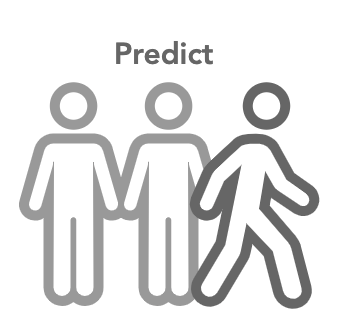

<a id = "101" ></a>
#### <b> KNN</b>
<a id = "knn" ></a>

In [12]:
knn_model = KNeighborsClassifier(n_neighbors = 11) 
knn_model.fit(X_train,y_train)
predicted_y = knn_model.predict(X_test)
accuracy_knn = knn_model.score(X_val,y_val)
print("KNN accuracy val:",accuracy_knn)
accuracy_knn = knn_model.score(X_test,y_test)
print("KNN accuracy test:",accuracy_knn)

KNN accuracy val: 0.7544783983140148
KNN accuracy test: 0.7676855895196506


In [13]:
print(classification_report(y_test, predicted_y))

              precision    recall  f1-score   support

           0       0.83      0.86      0.84      1667
           1       0.58      0.51      0.55       623

    accuracy                           0.77      2290
   macro avg       0.70      0.69      0.69      2290
weighted avg       0.76      0.77      0.76      2290



<a id = "102" ></a>
#### <b>SVC</b>
<a id = "svc" ></a>

In [14]:
svc_model = SVC(random_state = 1, probability = True)
svc_model.fit(X_train,y_train)
predict_y = svc_model.predict(X_test)
accuracy_svc = svc_model.score(X_val,y_val)
print("SVM accuracy val :",accuracy_svc)
accuracy_svc = svc_model.score(X_test,y_test)
print("SVM accuracy test :",accuracy_svc)
probs = svc_model.predict_proba(X_test)

SVM accuracy val : 0.7903055848261328
SVM accuracy test : 0.8034934497816594


In [15]:
print(classification_report(y_test, predict_y))

              precision    recall  f1-score   support

           0       0.83      0.93      0.87      1667
           1       0.71      0.48      0.57       623

    accuracy                           0.80      2290
   macro avg       0.77      0.70      0.72      2290
weighted avg       0.79      0.80      0.79      2290



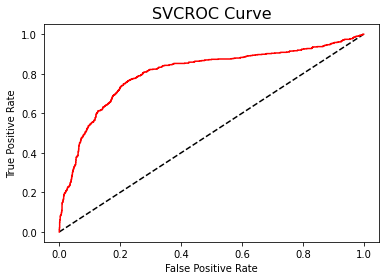

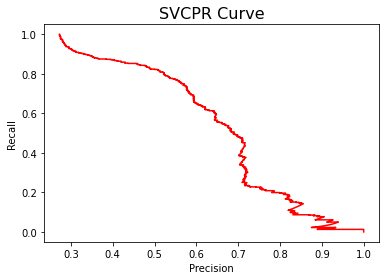

In [16]:
roc_curve_show(y_test, probs[:,1], 'SVC')
pr_curve_show(y_test, probs[:,1], 'SVC')

<a id = "103" ></a>
#### <b> Random Forest</b>
<a id = "rf" ></a>

In [17]:
model_rf = RandomForestClassifier(n_estimators=500 , oob_score = True, n_jobs = -1,
                                  random_state =50, max_features = "auto",
                                  max_leaf_nodes = 30)
model_rf.fit(X_train, y_train)

# Make predictions
prediction_test = model_rf.predict(X_test)
print (metrics.accuracy_score(y_test, prediction_test))
probs = model_rf.predict_proba(X_test)

0.7960698689956331


In [18]:
print(classification_report(y_test, prediction_test))

              precision    recall  f1-score   support

           0       0.83      0.91      0.87      1667
           1       0.67      0.48      0.56       623

    accuracy                           0.80      2290
   macro avg       0.75      0.70      0.72      2290
weighted avg       0.78      0.80      0.78      2290



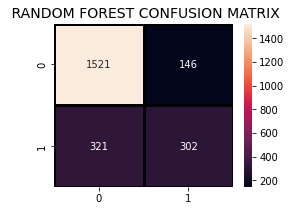

In [19]:
plt.figure(figsize=(4,3))
sns.heatmap(confusion_matrix(y_test, prediction_test),
                annot=True,fmt = "d",linecolor="k",linewidths=3)
    
plt.title(" RANDOM FOREST CONFUSION MATRIX",fontsize=14)
plt.show()

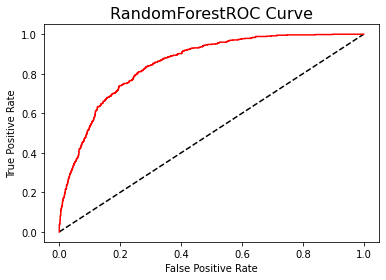

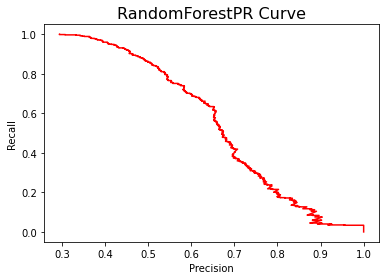

In [20]:
roc_curve_show(y_test, probs[:,1], 'RandomForest')
pr_curve_show(y_test, probs[:,1], 'RandomForest')

AxesSubplot(0.125,0.125;0.775x0.755)


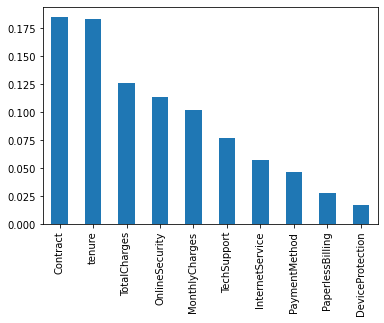

In [21]:
# To get the weights of all the variables
weights = pd.Series(np.absolute(model_rf.feature_importances_),
                 index=data[feature_cols].columns.values)
print (weights.sort_values(ascending = False)[:10].plot(kind='bar'))


<a id = "104" ></a>
#### <b>Logistic Regression</b>
<a id = "lr" ></a>

In [22]:
lr_model = LogisticRegression()
lr_model.fit(X_train,y_train)
accuracy_lr = lr_model.score(X_test,y_test)
print("Logistic Regression accuracy is :",accuracy_lr)

Logistic Regression accuracy is : 0.8052401746724891


In [23]:
lr_pred= lr_model.predict(X_test)
report = classification_report(y_test,lr_pred)
print(report)

              precision    recall  f1-score   support

           0       0.85      0.90      0.87      1667
           1       0.67      0.57      0.61       623

    accuracy                           0.81      2290
   macro avg       0.76      0.73      0.74      2290
weighted avg       0.80      0.81      0.80      2290



In [24]:
probs = lr_model.predict_proba(X_test)
probs

array([[0.43526244, 0.56473756],
       [0.66226441, 0.33773559],
       [0.58048796, 0.41951204],
       ...,
       [0.48462463, 0.51537537],
       [0.62428023, 0.37571977],
       [0.95505327, 0.04494673]])

AxesSubplot(0.125,0.125;0.775x0.755)


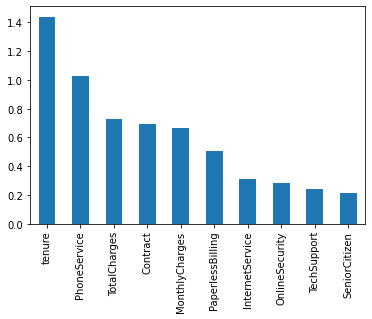

In [25]:
# To get the weights of all the variables
weights = pd.Series(np.absolute(lr_model.coef_[0]),
                 index=data[feature_cols].columns.values)
print (weights.sort_values(ascending = False)[:10].plot(kind='bar'))


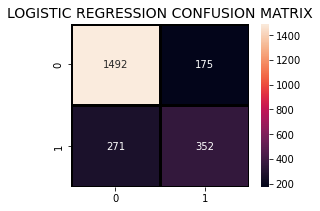

In [26]:
plt.figure(figsize=(4,3))
sns.heatmap(confusion_matrix(y_test, lr_pred),
                annot=True,fmt = "d",linecolor="k",linewidths=3)
    
plt.title("LOGISTIC REGRESSION CONFUSION MATRIX",fontsize=14)
plt.show()

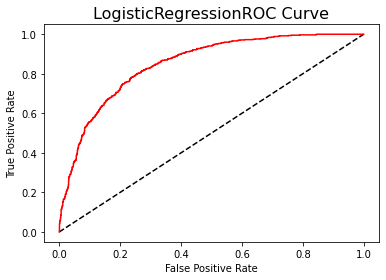

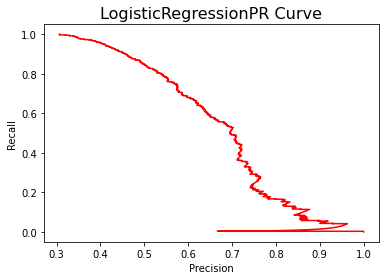

In [27]:
roc_curve_show(y_test, probs[:,1], 'LogisticRegression')
pr_curve_show(y_test, probs[:,1], 'LogisticRegression')

<a id = "105" ></a>
#### **Decision Tree Classifier**
<a id = "dtc" ></a>

In [28]:
dt_model = DecisionTreeClassifier()
dt_model.fit(X_train,y_train)
predictdt_y = dt_model.predict(X_test)
accuracy_dt = dt_model.score(X_test,y_test)
print("Decision Tree accuracy is :",accuracy_dt)

Decision Tree accuracy is : 0.7327510917030567


Decision tree gives very low score.

In [29]:
print(classification_report(y_test, predictdt_y))

              precision    recall  f1-score   support

           0       0.82      0.82      0.82      1667
           1       0.51      0.51      0.51       623

    accuracy                           0.73      2290
   macro avg       0.66      0.66      0.66      2290
weighted avg       0.73      0.73      0.73      2290



AxesSubplot(0.125,0.125;0.775x0.755)


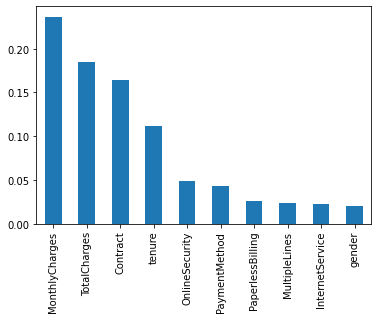

In [30]:
# To get the weights of all the variables
weights = pd.Series(np.absolute(dt_model.feature_importances_),
                 index=data[feature_cols].columns.values)
print (weights.sort_values(ascending = False)[:10].plot(kind='bar'))


<a id = "106" ></a>
#### **AdaBoost Classifier**
<a id = "ada" ></a>

In [31]:
a_model = AdaBoostClassifier()
a_model.fit(X_train,y_train)
a_preds = a_model.predict(X_test)
print("AdaBoost Classifier accuracy")
probs = a_model.predict_proba(X_test)
metrics.accuracy_score(y_test, a_preds)


AdaBoost Classifier accuracy


0.8

AxesSubplot(0.125,0.125;0.775x0.755)


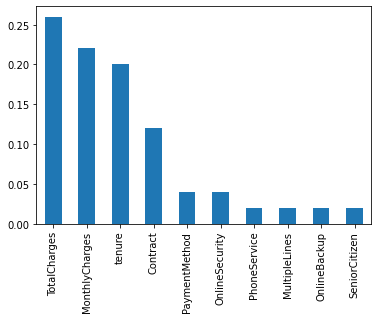

In [32]:
# To get the weights of all the variables
weights = pd.Series(np.absolute(a_model.feature_importances_),
                 index=data[feature_cols].columns.values)
print (weights.sort_values(ascending = False)[:10].plot(kind='bar'))


In [33]:
print(classification_report(y_test, a_preds))

              precision    recall  f1-score   support

           0       0.84      0.89      0.87      1667
           1       0.66      0.55      0.60       623

    accuracy                           0.80      2290
   macro avg       0.75      0.72      0.73      2290
weighted avg       0.79      0.80      0.79      2290



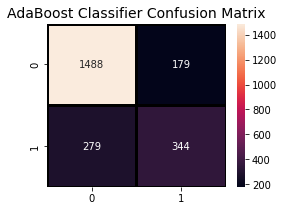

In [34]:
plt.figure(figsize=(4,3))
sns.heatmap(confusion_matrix(y_test, a_preds),
                annot=True,fmt = "d",linecolor="k",linewidths=3)
    
plt.title("AdaBoost Classifier Confusion Matrix",fontsize=14)
plt.show()

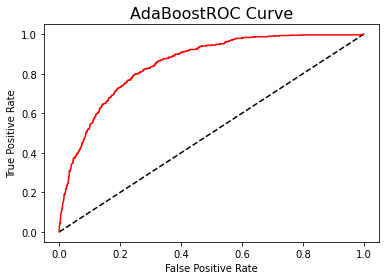

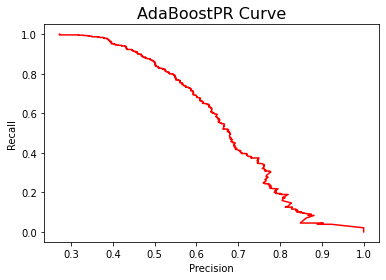

In [35]:
roc_curve_show(y_test, probs[:,1], 'AdaBoost')
pr_curve_show(y_test, probs[:,1], 'AdaBoost')

<a id = "107" ></a>
#### **Gradient Boosting Classifier**
<a id = "gb" ></a>

In [36]:
gb = GradientBoostingClassifier()
gb.fit(X_train, y_train)
gb_pred = gb.predict(X_test)
probs = a_model.predict_proba(X_test)
print("Gradient Boosting Classifier", accuracy_score(y_test, gb_pred))

Gradient Boosting Classifier 0.7995633187772926


AxesSubplot(0.125,0.125;0.775x0.755)


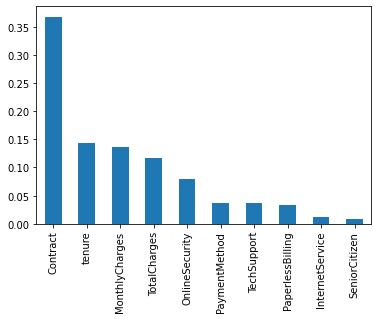

In [37]:
# To get the weights of all the variables
weights = pd.Series(np.absolute(gb.feature_importances_),
                 index=data[feature_cols].columns.values)
print (weights.sort_values(ascending = False)[:10].plot(kind='bar'))


In [38]:
print(classification_report(y_test, gb_pred))

              precision    recall  f1-score   support

           0       0.84      0.89      0.87      1667
           1       0.66      0.55      0.60       623

    accuracy                           0.80      2290
   macro avg       0.75      0.72      0.73      2290
weighted avg       0.79      0.80      0.79      2290



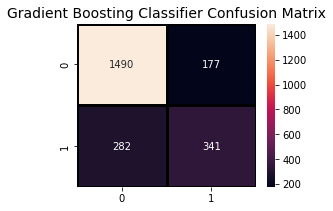

In [39]:
plt.figure(figsize=(4,3))
sns.heatmap(confusion_matrix(y_test, gb_pred),
                annot=True,fmt = "d",linecolor="k",linewidths=3)
    
plt.title("Gradient Boosting Classifier Confusion Matrix",fontsize=14)
plt.show()

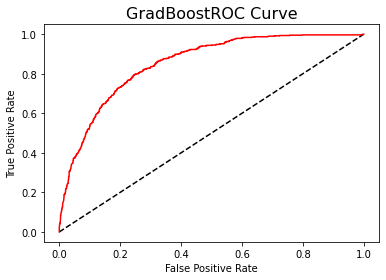

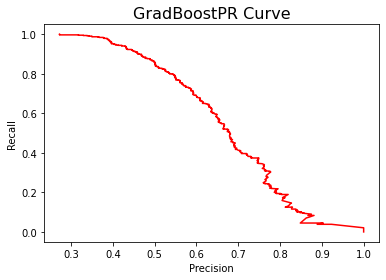

In [40]:
roc_curve_show(y_test, probs[:,1], 'GradBoost')
pr_curve_show(y_test, probs[:,1], 'GradBoost')

<a id = "108" ></a>
#### **Voting Classifier**
<a id = "vc" ></a>
Let's now predict the final model based on the highest majority of voting and check it's score.

In [41]:
from sklearn.ensemble import VotingClassifier
clf1 = GradientBoostingClassifier()
clf2 = LogisticRegression()
clf3 = AdaBoostClassifier()
eclf1 = VotingClassifier(estimators=[('gbc', clf1), ('lr', clf2), ('abc', clf3)], voting='soft')
eclf1.fit(X_train, y_train)
predictions = eclf1.predict(X_test)
print("Final Accuracy Score ")
print(accuracy_score(y_test, predictions))

Final Accuracy Score 
0.8052401746724891


In [42]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.84      0.90      0.87      1667
           1       0.67      0.55      0.61       623

    accuracy                           0.81      2290
   macro avg       0.76      0.73      0.74      2290
weighted avg       0.80      0.81      0.80      2290



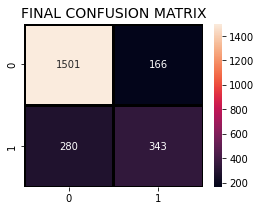

In [43]:
plt.figure(figsize=(4,3))
sns.heatmap(confusion_matrix(y_test, predictions),
                annot=True,fmt = "d",linecolor="k",linewidths=3)
    
plt.title("FINAL CONFUSION MATRIX",fontsize=14)
plt.show()

<a id = "108" ></a>
#### **Voting Classifier**
<a id = "vc" ></a>

In [44]:
from xgboost import XGBClassifier
model = XGBClassifier()
model.fit(X_train, y_train)
preds = model.predict(X_test)
probs = model.predict_proba(X_test)
metrics.accuracy_score(y_test, preds)


[08:35:09] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.780349344978166

In [45]:
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.83      0.88      0.85      1667
           1       0.62      0.51      0.56       623

    accuracy                           0.78      2290
   macro avg       0.72      0.70      0.71      2290
weighted avg       0.77      0.78      0.77      2290



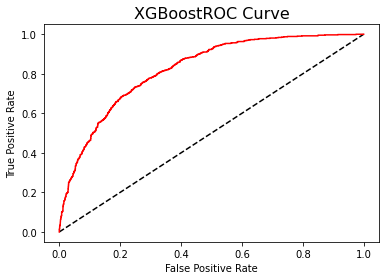

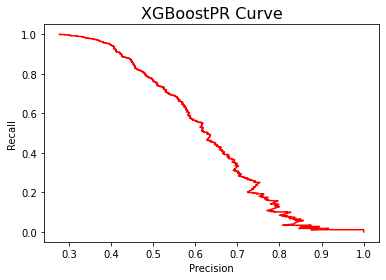

In [46]:
roc_curve_show(y_test, probs[:,1], 'XGBoost')
pr_curve_show(y_test, probs[:,1], 'XGBoost')

In [48]:
random_grid

{'n_estimators': [100, 111, 122, 133, 144, 155, 166, 177, 188, 200],
 'max_depth': [5, 6, 7, 8, 10],
 'learning_rate': [0.01, 0.1325, 0.255, 0.3775, 0.5],
 'min_child_weight': [1, 2, 3, 4]}

In [49]:
n_iter = 1
cross_val_fold = 2
n_jobs = 1

In [ ]:
xgb_clf = XGBClassifier(objective = 'binary:logistic', eval_metric = 'auc', scale_pos_weight = 2, use_label_encoder=False)
clf_random = RandomizedSearchCV(estimator = xgb_clf, param_distributions = random_grid, n_iter = n_iter, n_jobs = n_jobs, cv = cross_val_fold, verbose = 1, random_state = 42)
clf_random.fit(X_train, y_train)
#verbose
print(clf_random.best_params_)

Fitting 2 folds for each of 1 candidates, totalling 2 fits
